In [1]:
import os
import itertools
import matplotlib as mpl


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


width, height = set_size(252, fraction=1.0)
widht = 2 * width

# width = 5
# height = width/1.618
fontsize = 9

mpl.rcParams.update(
    {
        "font.size": fontsize,
        "figure.figsize": (width, height),
        "figure.facecolor": "white",
        "savefig.dpi": 360,
        "figure.subplot.bottom": 0.125,
        "figure.edgecolor": "white",
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    }
)

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from deephyper.skopt.moo import pareto_front, non_dominated_set, hypervolume
from deephyper.skopt.utils import cook_objective_scaler
from deephyper.search.hps import CBO

from deephyper.search.hps._mpi_doptuna import MPIDistributedOptuna

In [2]:
task_name = "navalpropulsion"
# task_name = "parkinsonstelemonitoring"
# task_name = "proteinstructure"
# task_name = "slicelocalization"
os.environ["DEEPHYPER_BENCHMARK_TASK"] = task_name
os.environ["DEEPHYPER_BENCHMARK_MOO"] = "1"

objective_columns = ["objective_0", "objective_1"]

repetitions = 10

max_evals = 200

In [3]:
import deephyper_benchmark as dhb

dhb.load("HPOBench/tabular")
from deephyper_benchmark.lib.hpobench.tabular import hpo

print(f"{hpo.DEEPHYPER_BENCHMARK_TASK=}")
print(f"{hpo.DEEPHYPER_BENCHMARK_MOO=}")

hpo.problem

hpo.DEEPHYPER_BENCHMARK_TASK='slicelocalization'
hpo.DEEPHYPER_BENCHMARK_MOO=True


Configuration space object:
  Hyperparameters:
    activation_fn_1, Type: Categorical, Choices: {tanh, relu}, Default: tanh
    activation_fn_2, Type: Categorical, Choices: {tanh, relu}, Default: tanh
    batch_size, Type: Ordinal, Sequence: {8, 16, 32, 64}, Default: 8
    dropout_1, Type: Ordinal, Sequence: {0.0, 0.3, 0.6}, Default: 0.0
    dropout_2, Type: Ordinal, Sequence: {0.0, 0.3, 0.6}, Default: 0.0
    init_lr, Type: Ordinal, Sequence: {0.0005, 0.001, 0.005, 0.01, 0.05, 0.1}, Default: 0.0005
    lr_schedule, Type: Categorical, Choices: {cosine, const}, Default: cosine
    n_units_1, Type: Ordinal, Sequence: {16, 32, 64, 128, 256, 512}, Default: 16
    n_units_2, Type: Ordinal, Sequence: {16, 32, 64, 128, 256, 512}, Default: 16

In [ ]:
scalers = ["identity", "minmaxlog", "log", "quantile-uniform", "minmax"]
strategies = ["Linear", "Chebyshev", "PBI"]

for i in range(1, repetitions):
    print(f"Starting round {i}...")

    # Random
    print("Random search...")
    results = CBO(
        hpo.problem,
        hpo.run,
        surrogate_model="DUMMY",
        objective_scaler="identity",
        moo_scalarization_strategy="Linear",
        log_dir=f"output/hpobench/{task_name}/{i}/random",
        verbose=1,
    ).search(max_evals=max_evals)

    # BO
    print("Bayesian optimization...")
    for scaler, strategy in itertools.product(scalers, strategies):
        result = CBO(
            hpo.problem,
            hpo.run,
            surrogate_model="RF",
            objective_scaler=scaler,
            moo_scalarization_strategy=strategy,
            log_dir=f"output/hpobench/{task_name}/{i}/{strategy.lower()}-{scaler}",
            verbose=1,
        ).search(max_evals=max_evals)

    # NSGAII
    print("NSGAII...")
    result = MPIDistributedOptuna(
        hpo.problem,
        hpo.run,
        sampler="NSGAII",
        n_objectives=2,
        log_dir=f"output/hpobench/{task_name}/{i}/nsgaii",
        verbose=1,
    ).search(max_evals=max_evals)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
from deephyper.search.hps._mpi_doptuna import MPIDistributedOptuna


results_nsgaii = MPIDistributedOptuna(
    hpo.problem,
    hpo.run,
    sampler="NSGAII",
    n_objectives=2,
    log_dir=f"output/hpobench/{task_name}/nsgaii",
    verbose=1,
).search(max_evals=max_evals)

results_nsgaii

[I 2023-07-12 15:37:50,758] A new study created in memory with name: no-name-9b69077f-210d-4fec-80c2-8f2659f1cb57
[I 2023-07-12 15:37:50,819] Trial 0 finished with values: [-0.01078296359628439, -314.7196655273434] and parameters: {'activation_fn_1': 'tanh', 'activation_fn_2': 'tanh', 'batch_size': 16, 'dropout_1': 0.3, 'dropout_2': 0.0, 'init_lr': 0.01, 'lr_schedule': 'cosine', 'n_units_1': 16, 'n_units_2': 16}. 
[I 2023-07-12 15:37:50,886] Trial 1 finished with values: [-0.9862521290779114, -352.94924926757847] and parameters: {'activation_fn_1': 'relu', 'activation_fn_2': 'relu', 'batch_size': 64, 'dropout_1': 0.3, 'dropout_2': 0.6, 'init_lr': 0.05, 'lr_schedule': 'cosine', 'n_units_1': 512, 'n_units_2': 32}. 
[I 2023-07-12 15:37:50,947] Trial 2 finished with values: [-0.9862487614154816, -821.0006103515636] and parameters: {'activation_fn_1': 'relu', 'activation_fn_2': 'relu', 'batch_size': 8, 'dropout_1': 0.3, 'dropout_2': 0.6, 'init_lr': 0.01, 'lr_schedule': 'cosine', 'n_units_1'

,p:activation_fn_1,p:activation_fn_2,p:batch_size,p:dropout_1,p:dropout_2,p:init_lr,p:lr_schedule,p:n_units_1,p:n_units_2,objective_0,objective_1,job_id,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val
0,tanh,tanh,16,0.3,0.0,0.0100,cosine,16,16,-0.010783,-314.719666,0,1.689169e+09,1.689169e+09,100,False,-0.010741,-0.010783
1,relu,relu,64,0.3,0.6,0.0500,cosine,512,32,-0.986252,-352.949249,1,1.689169e+09,1.689169e+09,100,False,-0.980696,-0.986252
2,relu,relu,8,0.3,0.6,0.0100,cosine,128,32,-0.986249,-821.000610,2,1.689169e+09,1.689169e+09,100,False,-0.980699,-0.986249
3,tanh,tanh,16,0.0,0.0,0.1000,const,64,32,-0.255277,-333.135498,3,1.689169e+09,1.689169e+09,100,False,-0.246231,-0.255277
4,relu,relu,16,0.6,0.0,0.1000,const,512,16,-1.004780,-947.351746,4,1.689169e+09,1.689169e+09,100,False,-1.003543,-1.004780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,relu,relu,16,0.0,0.0,0.0050,cosine,64,256,-0.000872,-387.683716,195,1.689169e+09,1.689169e+09,100,False,-0.001077,-0.000872
196,relu,relu,64,0.0,0.0,0.0050,cosine,256,32,-0.000411,-194.101410,196,1.689169e+09,1.689169e+09,100,False,-0.000381,-0.000411
197,relu,tanh,32,0.3,0.3,0.0050,cosine,64,64,-0.005983,-195.196014,197,1.689169e+09,1.689169e+09,100,False,-0.005779,-0.005983
198,relu,relu,32,0.0,0.6,0.0005,cosine,256,64,-0.004158,-367.831482,198,1.689169e+09,1.689169e+09,100,False,-0.004052,-0.004158


## Plots

In [12]:
# Impact of scalers
# exp_name = "comparing-scalers"
# scalers = ["identity", "minmaxlog", "log", "quantile-uniform", "minmax"]
# results_path = {
#     scaler_name: f"output/hpobench/{task_name}/linear-{scaler_name}"
#     for scaler_name in scalers
# }

# Impact of strategy
exp_name = "comparing-strategies"
scaler_name = "quantile-uniform"
strategies = ["Linear", "Chebyshev", "PBI"]
results_path = {
    strategy_name: f"output/hpobench/{task_name}/{strategy_name.lower()}-{scaler_name}"
    for strategy_name in strategies
}

results_path["random"] = f"output/hpobench/{task_name}/random"

In [13]:
results = {
    k: pd.read_csv(os.path.join(v, "results.csv")) for k, v in results_path.items()
}


def get_fitted_scaler_from_data(results, n_objectives, scaler_name="quantile-uniform"):
    objective_columns = [f"objective_{i}" for i in range(n_objectives)]
    objectives_concat = []
    for k, df in results.items():
        df[objective_columns] = -df[objective_columns]
        objectives_concat.append(df[objective_columns].values)
    objectives_concat = np.concatenate(objectives_concat, axis=0)

    scaler = cook_objective_scaler(scaler_name, None)
    scaler.fit(objectives_concat)
    return scaler


scaler = get_fitted_scaler_from_data(
    results, n_objectives=2, scaler_name="quantile-uniform"
)

/Users/romainegele/miniforge3/envs/dh-3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


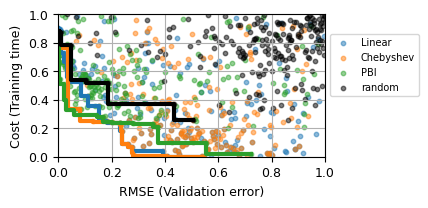

In [14]:
plt.figure(figsize=(width + width / 4, height))

for k, df in results.items():
    objectives = df[objective_columns].values
    objectives = scaler.transform(objectives)
    plt.scatter(
        objectives[:, 0],
        objectives[:, 1],
        label=k,
        s=10,
        alpha=0.5,
        c="black" if "random" in k else None,
    )

    pf = pareto_front(objectives, sort=True)

    plt.step(
        pf[:, 0],
        pf[:, 1],
        where="pre",
        c="black" if "random" in k else None,
        linewidth=3.0
        )

plt.xlabel("RMSE (Validation error)")
plt.ylabel("Cost (Training time)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=7)
plt.grid()
plt.tight_layout()
plt.savefig(f"output/hpobench/{task_name}/scatter-{exp_name}.png")
plt.show()

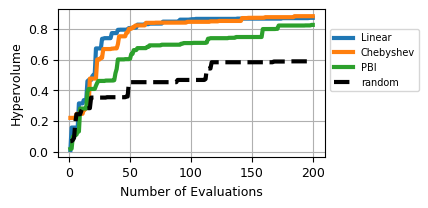

In [15]:
ref_point = np.array([1.0, 1.0])

plt.figure(figsize=(width+width/4, height))

for k, df in results.items():
    objectives = df[objective_columns].values
    objectives = scaler.transform(objectives)

    hv = []
    for i in range(len(df)):
        pf = pareto_front(objectives[: i + 1])
        hv.append(hypervolume(pf, ref=ref_point))

    if "random" in k:
        plot_kwargs = {"color": "black", "linewidth": 2, "linestyle": "--"}
    else:
        plot_kwargs = {}
    plot_kwargs["linewidth"] = 3.0
    
    plt.plot(np.arange(len(hv)) + 1, hv, label=k, **plot_kwargs)

plt.xlabel("Number of Evaluations")
plt.ylabel("Hypervolume")

plt.legend(bbox_to_anchor = (1.0, 0.9), fontsize=7)
plt.grid()
plt.tight_layout()
plt.savefig(f"output/hpobench/{task_name}/hv-comparing-{exp_name}.png")
plt.show()